Maastricht_University_logo.svg

# Information Retrieval and Text Mining Course - Tutorial Document Representation
Author: Gijs Wijngaard and Jan Scholtes

Version: 2025-2026

Welcome to the tutorial about **document representation**. A fundamental challenge in Information Retrieval and Text Mining is converting unstructured text into numerical representations that algorithms can process. In this notebook you will explore a progression of methods — from simple counting-based approaches to modern neural embeddings:

1. **One-Hot Encoding** — the simplest binary representation
2. **N-grams & Bag-of-Words** — counting word occurrences
3. **TF-IDF** — weighting terms by importance
4. **Cosine Similarity** — measuring document similarity
5. **Word2Vec** — learning dense word embeddings
6. **Sentence Transformers** — contextual sentence embeddings

---

## 1. One-Hot Encoding

The simplest way to represent words as numbers is **one-hot encoding**. Given a vocabulary $V = \{w_1, w_2, \ldots, w_{|V|}\}$, each word $w_i$ is represented as a binary vector $\mathbf{e}_i \in \{0, 1\}^{|V|}$ where:

$$
\mathbf{e}_i[j] = \begin{cases} 1 & \text{if } j = i \\ 0 & \text{otherwise} \end{cases}
$$

For example, with vocabulary $V = \{\text{cat}, \text{dog}, \text{fox}\}$:
- cat $\rightarrow [1, 0, 0]$
- dog $\rightarrow [0, 1, 0]$
- fox $\rightarrow [0, 0, 1]$

**Limitations:**
- Vectors are very high-dimensional (size of vocabulary, typically 10,000+)
- All word vectors are **orthogonal** — there is no notion of similarity ($\text{cosine}(\mathbf{e}_i, \mathbf{e}_j) = 0$ for $i \neq j$)
- No semantic information is captured ("king" and "queen" are as different as "king" and "banana")

In [1]:
import numpy as np

sentence = "the quick brown fox jumps over the lazy dog"
words = sentence.split()
vocabulary = sorted(set(words))

print(f"Vocabulary ({len(vocabulary)} unique words): {vocabulary}\n")

# Create one-hot vectors for each unique word
one_hot = {word: np.eye(len(vocabulary))[i].astype(int) for i, word in enumerate(vocabulary)}

for word, vector in one_hot.items():
    print(f"  {word:6s} → {vector}")

Vocabulary (8 unique words): ['brown', 'dog', 'fox', 'jumps', 'lazy', 'over', 'quick', 'the']

  brown  → [1 0 0 0 0 0 0 0]
  dog    → [0 1 0 0 0 0 0 0]
  fox    → [0 0 1 0 0 0 0 0]
  jumps  → [0 0 0 1 0 0 0 0]
  lazy   → [0 0 0 0 1 0 0 0]
  over   → [0 0 0 0 0 1 0 0]
  quick  → [0 0 0 0 0 0 1 0]
  the    → [0 0 0 0 0 0 0 1]


## 2. N-grams and Bag-of-Words

Instead of representing individual words, we can capture **sequences** of words. An **n-gram** is a contiguous sequence of $n$ items from a text. Given a sequence of tokens $w_1, w_2, \ldots, w_m$, the set of n-grams is:

$$
\text{ngrams}(n) = \{(w_i, w_{i+1}, \ldots, w_{i+n-1}) \mid 1 \leq i \leq m - n + 1\}
$$

Let's see this in practice with our example sentence:

In [2]:
sentence = "the quick brown fox jumps over the lazy dog"

A **bigram** ($n=2$) groups two consecutive words together. Bigrams capture local word co-occurrence patterns:

In [3]:
splitted = sentence.split(" ")
[bigram for bigram in zip(splitted, splitted[1:])]

[('the', 'quick'),
 ('quick', 'brown'),
 ('brown', 'fox'),
 ('fox', 'jumps'),
 ('jumps', 'over'),
 ('over', 'the'),
 ('the', 'lazy'),
 ('lazy', 'dog')]

With the grouping of 3 words together, we call it a trigram.

In [4]:
[trigram for trigram in zip(splitted, splitted[1:], splitted[2:])]

[('the', 'quick', 'brown'),
 ('quick', 'brown', 'fox'),
 ('brown', 'fox', 'jumps'),
 ('fox', 'jumps', 'over'),
 ('jumps', 'over', 'the'),
 ('over', 'the', 'lazy'),
 ('the', 'lazy', 'dog')]

### Bag-of-Words (BoW)

A **Bag-of-Words** representation ignores word order entirely and represents a document as a vector of word counts. Given vocabulary $V = \{w_1, \ldots, w_{|V|}\}$, a document $d$ is represented as:

$$
\mathbf{d} = [\text{tf}(w_1, d), \text{tf}(w_2, d), \ldots, \text{tf}(w_{|V|}, d)]
$$

where $\text{tf}(w, d)$ is the **term frequency** — the number of times word $w$ appears in document $d$.

In [5]:
from collections import Counter
bag_of_words = Counter(splitted)
print("Bag-of-Words representation:")
for word, count in bag_of_words.items():
    print(f"  {word}: {count}")

Bag-of-Words representation:
  the: 2
  quick: 1
  brown: 1
  fox: 1
  jumps: 1
  over: 1
  lazy: 1
  dog: 1


Notice that "the" has a count of 2, while all other words appear once. Words like "the", "a", "and" are called **stop words** — they are extremely common but carry little meaning about the document's topic. We need a weighting scheme that reduces the importance of such words. This is where **TF-IDF** comes in.

<a name="dataset"></a>

## 3. Dataset

We use a [movie review dataset](https://www.cs.cornell.edu/people/pabo/movie-review-data/) from NLTK. This dataset contains **1000 positive** and **1000 negative** movie reviews, making it suitable for **sentiment analysis** — classifying reviews as positive or negative based on their word content.

In [6]:
import nltk
nltk.download('movie_reviews')
nltk.download('words')
from nltk.corpus import words, movie_reviews as mr
nltk_words = set(words.words())

[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\jcsch\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\movie_reviews.zip.
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\jcsch\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


We first remove the punctuation from all the words, and afterwards we count the most common words.

In [7]:
import string
from collections import Counter
def remove_punct(word):
    word = word.translate(str.maketrans('', '', string.punctuation))
    return word if word in nltk_words else ''
all_words = Counter(filter(remove_punct, mr.words()))
all_words.most_common(10)

[('the', 76529),
 ('a', 38106),
 ('and', 35576),
 ('of', 34123),
 ('to', 31937),
 ('is', 25195),
 ('in', 21822),
 ('s', 18513),
 ('it', 16107),
 ('that', 15924)]

The same problem we have here. Words such as *the* and *a* are the most common amongst the movie reviews of our dataset. However, to do something with the movie review, such as classifying it, we should give a lower probability to these words, as they do not say much about the content itself.

In [8]:
documents = [(list(filter(remove_punct, mr.words(f))), mr.categories(f)) for f in mr.fileids()]
print("Total number of documents:", len(documents))
print("Total number of words in first document:", len(documents[0][0]))

Total number of documents: 2000
Total number of words in first document: 636


## 4. TF-IDF (Term Frequency–Inverse Document Frequency)

TF-IDF assigns a **weight** to each term in a document that reflects how important that term is relative to the collection. The score **increases** with the number of occurrences in a document and **increases** with the rarity of the term across all documents.

The TF-IDF weight of term $t$ in document $d$ is:

$$
w_{t,d} = \text{tf-idf}(t, d) = \log(1 + \text{tf}_{t,d}) \times \log_{10}\!\left(\frac{N}{\text{df}_t}\right)
$$

where:
- $\text{tf}_{t,d}$ = **term frequency**: number of times term $t$ appears in document $d$
- $\text{df}_t$ = **document frequency**: number of documents in the collection containing term $t$
- $N$ = total number of documents in the collection
- $\log(1 + \text{tf}_{t,d})$ applies **sublinear** scaling — a word appearing 10× is not 10× as important
- $\log_{10}(N / \text{df}_t)$ is the **inverse document frequency (IDF)** — rare terms get higher weight

**Key insight**: A term gets a high TF-IDF score when it appears frequently in a specific document (high TF) but rarely across the collection (high IDF). Common words like "the" will have $\text{df}_t \approx N$, giving $\text{IDF} \approx 0$.

> **Note:** There are many TF-IDF variants. A popular alternative is **BM25** (Best Matching 25), which adds document length normalization and a saturation parameter. BM25 is used by search engines like Elasticsearch and Solr.

Lets start with calculating the term frequency (tf). Now, we calculated the number of words for all documents. However, to calculate the tf-idf score we need to calculate the term-frequency for each term per document. Thus, we need to loop over the documents and count the occurrences of the terms per document.

In [9]:
tf = [Counter(words) for words, category in documents]
tf[0].most_common(10) # Most common terms for the first document

[('the', 38),
 ('it', 25),
 ('and', 20),
 ('to', 16),
 ('of', 16),
 ('a', 14),
 ('that', 13),
 ('are', 13),
 ('is', 12),
 ('but', 10)]

Now let's calculate the **document frequency** ($\text{df}$). For each word in our vocabulary, we count how many documents contain that word. We convert each document to a `set` (unique words) so that membership lookup is $O(1)$ instead of $O(n)$:

In [10]:
setted_docs = [set(doc) for doc, category in documents]
df = {word: sum([1 for doc in setted_docs if word in doc]) for word in all_words.keys()}
list(df.items())[:10]

[('plot', 892),
 ('two', 1062),
 ('teen', 105),
 ('go', 751),
 ('to', 1997),
 ('a', 1996),
 ('church', 44),
 ('party', 112),
 ('drink', 28),
 ('and', 1998)]

### Computing TF-IDF from Scratch

Now let's implement the TF-IDF formula ourselves using `numpy`. For each document, we loop over its words and compute the TF-IDF weight. Notice how we use `np.log` for the sublinear TF scaling and `np.log10` for the IDF:

> **Observe**: After running this, look at which words get the highest TF-IDF scores. Are they the common words like "the" and "a", or more distinctive words?

In [ ]:
import numpy as np

N = len(documents)

# Compute TF-IDF for each word in each document
tfidf = []
for i in range(N):
    tfidf_doc = {}
    for word, count in tf[i].items():
        tfidf_doc[word] = np.log(1 + count) * np.log10(N / df[word])
    tfidf.append(tfidf_doc)

# Check: print top 5 TF-IDF terms for the first document
sorted_first = sorted(tfidf[0].items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 TF-IDF terms for document 1:")
for word, score in sorted_first:
    print(f"  {word}: {score:.4f}")

# Compare with a common word
if "the" in tfidf[0]:
    print(f"\n  'the' TF-IDF: {tfidf[0]['the']:.4f}  ← very low because it appears in nearly every document")

Top 5 TF-IDF terms for document 1:
  memento: 3.1024
  strangeness: 2.8587
  highway: 2.2475
  crow: 2.1305
  snag: 2.0794


### Comparing TF-IDF across Positive and Negative Reviews

Let's see whether positive and negative movie reviews use distinctive words. We compute the **average TF-IDF** per word separately for positive and negative reviews:

> **Observe**: Look at the top words for each sentiment. Do you see sentiment-related words ("great", "bad") or mostly movie-related words ("film", "story")? What does this tell us about using TF-IDF for classification?

In [ ]:
# Separate positive and negative documents
pos_indices = [i for i, (_, cat) in enumerate(documents) if 'pos' in cat]
neg_indices = [i for i, (_, cat) in enumerate(documents) if 'neg' in cat]

# Average TF-IDF per word for positive reviews
pos_avg = {}
for i in pos_indices:
    for word, score in tfidf[i].items():
        pos_avg[word] = pos_avg.get(word, 0) + score
pos_avg = {w: s / len(pos_indices) for w, s in pos_avg.items()}

# Average TF-IDF per word for negative reviews
neg_avg = {}
for i in neg_indices:
    for word, score in tfidf[i].items():
        neg_avg[word] = neg_avg.get(word, 0) + score
neg_avg = {w: s / len(neg_indices) for w, s in neg_avg.items()}

top_positive = sorted(pos_avg.items(), key=lambda x: x[1], reverse=True)[:20]
top_negative = sorted(neg_avg.items(), key=lambda x: x[1], reverse=True)[:20]

print("Top 20 words in POSITIVE reviews:")
for word, score in top_positive:
    print(f"  {word}: {score:.4f}")

print("\nTop 20 words in NEGATIVE reviews:")
for word, score in top_negative:
    print(f"  {word}: {score:.4f}")

# Find words unique to each list
pos_words = set(w for w, _ in top_positive)
neg_words = set(w for w, _ in top_negative)
print(f"\nWords only in positive top-20: {pos_words - neg_words}")
print(f"Words only in negative top-20: {neg_words - pos_words}")
print(f"Shared words: {pos_words & neg_words}")

Top 20 words in POSITIVE reviews:
  her: 0.2069
  life: 0.1975
  she: 0.1962
  world: 0.1807
  great: 0.1806
  very: 0.1754
  many: 0.1719
  him: 0.1686
  both: 0.1680
  best: 0.1669
  also: 0.1663
  its: 0.1656
  love: 0.1655
  performance: 0.1643
  will: 0.1621
  family: 0.1619
  we: 0.1612
  story: 0.1611
  new: 0.1609
  although: 0.1607

Top 20 words in NEGATIVE reviews:
  bad: 0.2139
  she: 0.1923
  her: 0.1865
  action: 0.1751
  plot: 0.1726
  why: 0.1676
  me: 0.1656
  my: 0.1636
  script: 0.1606
  re: 0.1598
  then: 0.1589
  we: 0.1588
  nothing: 0.1562
  big: 0.1549
  could: 0.1546
  any: 0.1545
  don: 0.1538
  had: 0.1537
  no: 0.1521
  really: 0.1520


### Visualizing TF-IDF Weights

Let's visualize how TF-IDF assigns different weights to words. We use scikit-learn's `TfidfVectorizer` to compute TF-IDF on a small set of example documents and display the result as a heatmap:

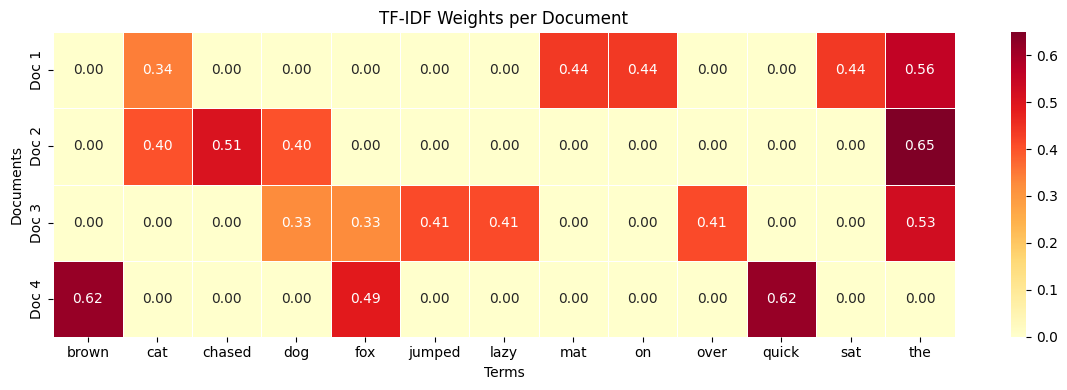


Notice how common words like 'the' get lower weights,
while distinctive words like 'mat', 'jumped', 'quick' get higher weights.


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Small example corpus
example_docs = [
    "the cat sat on the mat",
    "the dog chased the cat",
    "the fox jumped over the lazy dog",
    "a quick brown fox"
]

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(example_docs)
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame for visualization
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names,
                        index=[f"Doc {i+1}" for i in range(len(example_docs))])

plt.figure(figsize=(12, 4))
sns.heatmap(tfidf_df, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=0.5)
plt.title("TF-IDF Weights per Document")
plt.ylabel("Documents")
plt.xlabel("Terms")
plt.tight_layout()
plt.show()

print("\nNotice how common words like 'the' get lower weights,")
print("while distinctive words like 'mat', 'jumped', 'quick' get higher weights.")

## 5. Cosine Similarity

Once we have vector representations of documents (whether BoW, TF-IDF, or embeddings), we need a way to measure **how similar** two documents are. The most commonly used measure in IR is **cosine similarity**.

For two vectors $\mathbf{a}$ and $\mathbf{b}$, cosine similarity is defined as:

$$
\text{cos}(\mathbf{a}, \mathbf{b}) = \frac{\mathbf{a} \cdot \mathbf{b}}{\|\mathbf{a}\| \, \|\mathbf{b}\|} = \frac{\sum_{i=1}^{n} a_i \, b_i}{\sqrt{\sum_{i=1}^{n} a_i^2} \cdot \sqrt{\sum_{i=1}^{n} b_i^2}}
$$

- The result ranges from $-1$ (opposite) to $1$ (identical direction), with $0$ meaning orthogonal (unrelated).
- For non-negative vectors (like TF-IDF), the range is $[0, 1]$.
- Cosine similarity measures **angle**, not magnitude — a long document and a short document with the same word proportions will have high similarity.

Let's compute the cosine similarity between our example TF-IDF documents:

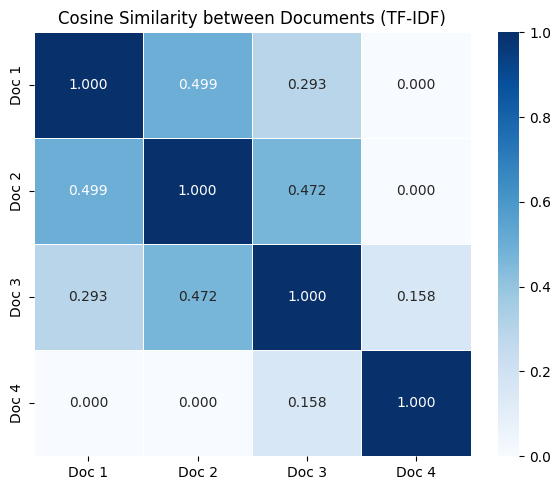

Documents:
  Doc 1: "the cat sat on the mat"
  Doc 2: "the dog chased the cat"
  Doc 3: "the fox jumped over the lazy dog"
  Doc 4: "a quick brown fox"

Doc 1 and Doc 2 share 'the' and 'cat' → moderate similarity
Doc 3 and Doc 4 share 'fox' → some similarity
Doc 1 and Doc 4 share nothing meaningful → low similarity


In [15]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute pairwise cosine similarity on TF-IDF vectors
cos_sim = cosine_similarity(tfidf_matrix)
cos_df = pd.DataFrame(cos_sim, 
                       index=[f"Doc {i+1}" for i in range(len(example_docs))],
                       columns=[f"Doc {i+1}" for i in range(len(example_docs))])

plt.figure(figsize=(6, 5))
sns.heatmap(cos_df, annot=True, fmt=".3f", cmap="Blues", vmin=0, vmax=1, linewidths=0.5)
plt.title("Cosine Similarity between Documents (TF-IDF)")
plt.tight_layout()
plt.show()

print("Documents:")
for i, doc in enumerate(example_docs):
    print(f"  Doc {i+1}: \"{doc}\"")
print("\nDoc 1 and Doc 2 share 'the' and 'cat' → moderate similarity")
print("Doc 3 and Doc 4 share 'fox' → some similarity")
print("Doc 1 and Doc 4 share nothing meaningful → low similarity")

## 6. Word2Vec — Dense Word Embeddings

So far, our representations have been **sparse** and **high-dimensional** (one dimension per vocabulary word). Word2Vec (Mikolov et al., 2013) learns **dense, low-dimensional** vectors (typically 100-300 dimensions) where **semantically similar words are close together** in vector space.

The core idea is the **distributional hypothesis**: *"A word is characterized by the company it keeps."* (Firth, 1957)

Word2Vec has two training architectures:

1. **Skip-gram**: Given a center word $w_t$, predict context words $w_{t+j}$ within a window of size $c$. The objective maximizes:

$$
\frac{1}{T} \sum_{t=1}^{T} \sum_{-c \leq j \leq c, \, j \neq 0} \log P(w_{t+j} \mid w_t)
$$

where 

$$
P(w_O \mid w_I) = \frac{\exp(\mathbf{v}'_{w_O} \cdot \mathbf{v}_{w_I})}{\sum_{w=1}^{|V|} \exp(\mathbf{v}'_w \cdot \mathbf{v}_{w_I})}
$$

2. **CBOW (Continuous Bag of Words)**: Given context words, predict the center word. Faster to train but less effective on rare words.

In practice, **negative sampling** is used instead of the full softmax to make training tractable.

The most common implementation for Word2Vec in Python is [gensim](https://radimrehurek.com/gensim/models/word2vec.html). Let's train Word2Vec on our movie reviews:

In [16]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=[doc for doc, cat in documents])
word_vectors = model.wv
word_vectors['the']

array([-0.4490691 , -0.35211685, -0.5818292 ,  0.7259471 , -0.9648102 ,
       -0.99351627,  1.8227882 ,  0.6590131 , -0.8989716 , -0.2537687 ,
        1.0615484 ,  0.20431101, -0.7944958 , -0.92710626, -0.78612643,
       -0.01665432,  0.9708325 ,  0.7632571 , -0.5767834 ,  0.34306562,
        1.2454556 ,  1.2182798 ,  0.41502103, -0.28308284,  0.721877  ,
        0.58779776,  0.51489675,  0.6225661 , -1.1991363 , -1.2986798 ,
       -1.0993838 ,  0.12867133,  0.6847387 , -0.59114397, -1.221551  ,
       -0.29447973,  0.9864842 , -0.8324289 ,  0.4279743 , -0.5339707 ,
       -0.48783043,  0.06066274, -0.40554625, -0.9263374 ,  0.13180085,
       -0.09096839, -0.06038285,  0.3851545 ,  0.18330804,  0.58614844,
       -0.17891817,  0.11177585, -0.26771364, -0.10077428,  0.6333316 ,
       -0.71737874, -0.53913367, -0.46009266, -0.5916928 ,  0.7994409 ,
        0.12450138, -0.39429215, -0.33050212, -0.7426311 ,  0.09887524,
        0.55068856, -0.09884448, -0.02069594, -0.4415725 ,  0.76

We can find the most similar vector nearby a word using `most_similar`.

In [17]:
word_vectors.most_similar('king')

[('queen', 0.8442586064338684),
 ('leader', 0.8418267965316772),
 ('former', 0.831785261631012),
 ('pilot', 0.8233455419540405),
 ('partner', 0.8231845498085022),
 ('fellow', 0.8217923641204834),
 ('president', 0.8207924365997314),
 ('chief', 0.8158081769943237),
 ('investigator', 0.8153656125068665),
 ('bill', 0.8136593103408813)]

And we can even do arithmetic with it. The most famous example of this is the `king + man - woman = queen` analogy. By adding the vector of king and man to each other, and subtracting the vector of woman, we should get the queen vector. Lets try!

In [18]:
word_vectors.most_similar(positive=['king','woman'],negative=['man'])

[('queen', 0.8448281288146973),
 ('jane', 0.829059362411499),
 ('hall', 0.79975825548172),
 ('lori', 0.7993390560150146),
 ('princess', 0.7888410091400146),
 ('domineering', 0.7870669364929199),
 ('kelly', 0.7802510857582092),
 ('abusive', 0.7792026400566101),
 ('anna', 0.7789353728294373),
 ('martin', 0.7772242426872253)]

We get queen as the second most similar vector. We only trained our word2vec model on our reviews dataset which is a small dataset for word2vec standards, so that makes sense.

Lastly, lets plot the data. For this, we need to represent our vectors as a 2-d space. For this, we need a dimensionality reduction technique, such as PCA or t-SNE. We use t-SNE (invented by someone who did the same master as you are doing!). It might take a while to compute the vectors below:

In [19]:
from sklearn.manifold import TSNE
import numpy as np
tsne = TSNE(n_components=2, random_state=0)
vectors = tsne.fit_transform(np.asarray(model.wv.vectors))
x, y = zip(*vectors)

In [20]:
len(x), len(y)

(8798, 8798)

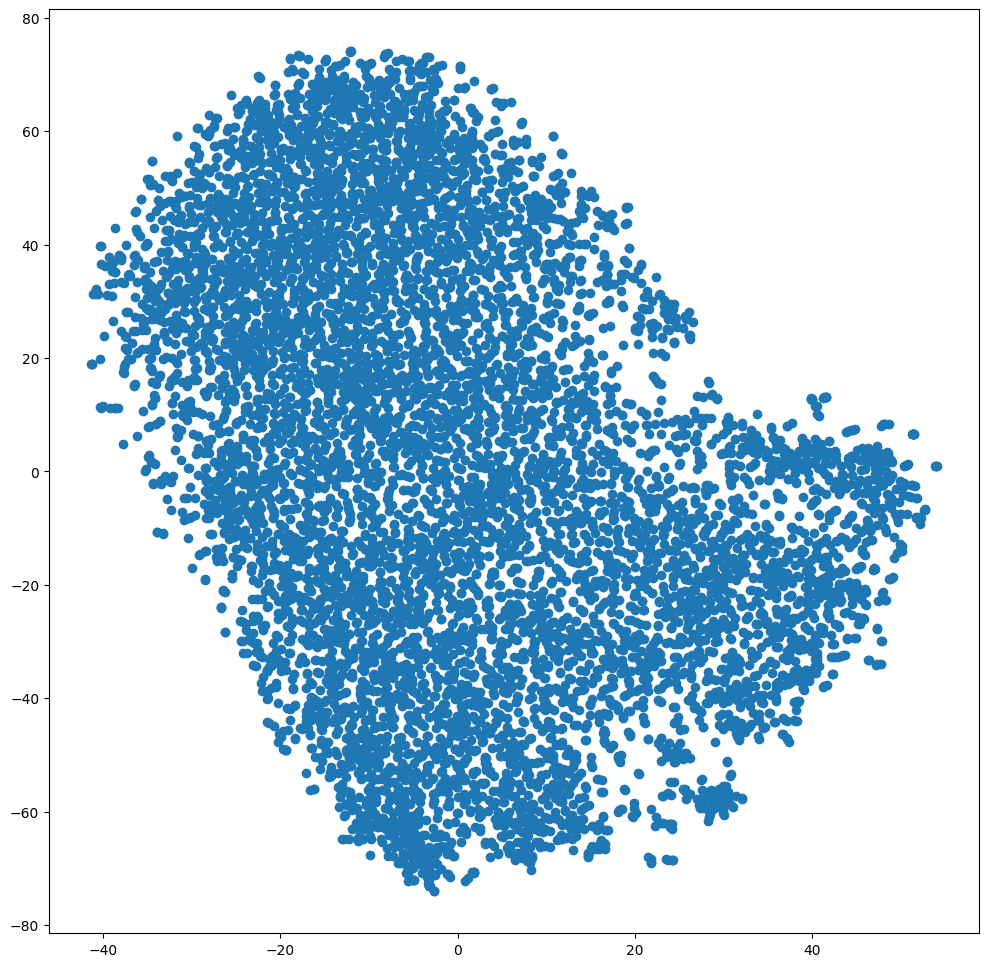

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
plt.scatter(x, y)

## 7. Pretrained Word Embeddings (GloVe)

Word2Vec works best with **pretrained embeddings** — vectors trained on massive corpora by researchers and made publicly available.

**GloVe** (Global Vectors, Pennington et al., 2014) is a popular alternative to Word2Vec. While Word2Vec uses local context windows, GloVe combines:
- **Global co-occurrence statistics** (how often words appear together across the entire corpus)  
- **Local context** (word-word co-occurrence within windows)

GloVe optimizes the objective:

$$
J = \sum_{i,j=1}^{|V|} f(X_{ij}) \left( \mathbf{w}_i^T \tilde{\mathbf{w}}_j + b_i + \tilde{b}_j - \log X_{ij} \right)^2
$$

where $X_{ij}$ is the co-occurrence count and $f$ is a weighting function that prevents very common co-occurrences from dominating.

Let's download pretrained GloVe vectors (trained on Wikipedia + Gigaword, 6B tokens):

In [22]:
import gensim.downloader
glove = gensim.downloader.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 66.0/66.0MB downloaded


In [23]:
glove["king"]

array([ 0.50451 ,  0.68607 , -0.59517 , -0.022801,  0.60046 , -0.13498 ,
       -0.08813 ,  0.47377 , -0.61798 , -0.31012 , -0.076666,  1.493   ,
       -0.034189, -0.98173 ,  0.68229 ,  0.81722 , -0.51874 , -0.31503 ,
       -0.55809 ,  0.66421 ,  0.1961  , -0.13495 , -0.11476 , -0.30344 ,
        0.41177 , -2.223   , -1.0756  , -1.0783  , -0.34354 ,  0.33505 ,
        1.9927  , -0.04234 , -0.64319 ,  0.71125 ,  0.49159 ,  0.16754 ,
        0.34344 , -0.25663 , -0.8523  ,  0.1661  ,  0.40102 ,  1.1685  ,
       -1.0137  , -0.21585 , -0.15155 ,  0.78321 , -0.91241 , -1.6106  ,
       -0.64426 , -0.51042 ], dtype=float32)

### Sentiment Classification with GloVe

Let's see how well GloVe embeddings can be used for sentiment classification. The approach:

1. For each document, get the GloVe vector for every word (skip words not in the vocabulary)
2. **Average** all word vectors to create a single document embedding
3. Split into 80/20 train/test
4. Train a `LogisticRegression` classifier

> **Observe**: Note the libraries we use (`train_test_split`, `LogisticRegression`, `accuracy_score`) and how we handle words missing from the GloVe vocabulary. Also note how we average word vectors with `np.mean(vectors, axis=0)` — this is a common technique to get a document-level representation from word embeddings.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Create averaged GloVe vectors for each document
X_glove = []
y_labels = []
for words, categories in documents:
    word_vectors = [glove[w] for w in words if w in glove]   # skip unknown words
    if word_vectors:
        X_glove.append(np.mean(word_vectors, axis=0))        # average all word vectors
    else:
        X_glove.append(np.zeros(50))  # fallback: zero vector for GloVe-50d
    y_labels.append(1 if 'pos' in categories else 0)

X_glove = np.array(X_glove)
y_labels = np.array(y_labels)

print(f"Document matrix shape: {X_glove.shape}  (2000 docs × 50 dimensions)")

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_glove, y_labels, test_size=0.2, random_state=42
)

# Train a Logistic Regression classifier
clf_glove = LogisticRegression(max_iter=1000, random_state=42)
clf_glove.fit(X_train, y_train)

# Predict and evaluate with Precision, Recall, F1
y_pred = clf_glove.predict(X_test)
print("GloVe + LogisticRegression:\n")
print(classification_report(y_test, y_pred, target_names=["negative", "positive"]))

GloVe + LogisticRegression Accuracy: 0.7200


## Bias in Word2Vec
One of the problems with Word2Vec (and with machine learning in general) is that there is lots of biases assumed by the model. Examples of biases that can be harmful when using these algorithms include gender bias and ethnicity bias. Lets check for example what happens if we take the female equivalent of `doctor`:

In [26]:
glove.most_similar(positive=['doctor','woman'],negative=['man'])

[('nurse', 0.8404642939567566),
 ('child', 0.7663259506225586),
 ('pregnant', 0.7570130228996277),
 ('mother', 0.7517457604408264),
 ('patient', 0.7516663074493408),
 ('physician', 0.7507280707359314),
 ('dentist', 0.7360344529151917),
 ('therapist', 0.7342537045478821),
 ('parents', 0.7286345958709717),
 ('surgeon', 0.7165213823318481)]

### Exploring Bias in Word Embeddings

Word embeddings learn associations from training data — including societal biases present in that data. Let's explore **gender bias** and **professional stereotypes** using analogy queries.

> **Observe**: Look at the analogy results below. What patterns do you notice? Are these associations factual, or do they reflect harmful stereotypes?

**Why do these biases exist?**

Word embeddings are trained on large corpora of web text, news articles, and books that reflect historical and societal prejudices. When these embeddings are used in downstream applications — such as search engines, chatbots, hiring tools, or criminal justice risk assessment — they can **perpetuate and amplify discrimination**.

For example, if a resume-screening system uses GloVe embeddings that associate "programmer" more closely with "man" than "woman", it may systematically rank male candidates higher. This is an active area of research in **AI fairness** and **debiasing** (Bolukbasi et al., 2016).

In [ ]:
# Example 1: Gender bias in professions
print("man:programmer :: woman:?")
print(glove.most_similar(positive=['programmer', 'woman'], negative=['man'])[:5])

print("\nman:doctor :: woman:?")
print(glove.most_similar(positive=['doctor', 'woman'], negative=['man'])[:5])

# Example 2: Professional stereotypes
print("\nfather:doctor :: mother:?")
print(glove.most_similar(positive=['doctor', 'mother'], negative=['father'])[:5])

man:programmer :: woman:?
[('prodigy', 0.6731117367744446), ('therapist', 0.6414065361022949), ('psychotherapist', 0.6201493144035339), ('technician', 0.6191534996032715), ('programmers', 0.59874427318573)]

man:doctor :: woman:?
[('nurse', 0.8404642939567566), ('child', 0.7663259506225586), ('pregnant', 0.7570130228996277), ('mother', 0.7517457604408264), ('patient', 0.7516663074493408)]

father:doctor :: mother:?
[('nurse', 0.8452296853065491), ('patient', 0.8042120933532715), ('pregnant', 0.7976154088973999), ('child', 0.7907556891441345), ('woman', 0.7754611372947693)]


## 8. Sentence Transformers — Contextual Embeddings

A key limitation of Word2Vec and GloVe is that they produce **static embeddings** — each word has exactly one vector regardless of context. The word "bank" gets the same vector whether it means "river bank" or "financial bank".

**Transformer-based models** (like BERT) solve this by producing **contextual embeddings** — the vector for each word depends on its surrounding context. These models use the **self-attention mechanism**:

$$
\text{Attention}(Q, K, V) = \text{softmax}\!\left(\frac{QK^T}{\sqrt{d_k}}\right) V
$$

where $Q$, $K$, $V$ are query, key, and value matrices derived from input embeddings, and $d_k$ is the dimension of the keys.

**Sentence Transformers** (Reimers & Gurevych, 2019) extend BERT by applying **mean pooling** over all token embeddings to produce a single fixed-size vector for an entire sentence. This is efficient and well-suited for tasks like:
- Semantic search
- Sentence similarity
- Clustering
- Sentiment classification

| Feature | Word2Vec / GloVe | Sentence Transformers |
|:--------|:-----------------|:---------------------|
| Type | Static | Contextual |
| Granularity | Word-level | Sentence-level |
| Polysemy | One vector per word | Context-dependent |
| Training data | Co-occurrence | Masked language model |
| Typical dims | 50–300 | 384–1024 |

Let's load a sentence transformer model:

In [28]:
from sentence_transformers import SentenceTransformer
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

c:\Users\jcsch\OneDrive - Dennenhof Capital BV\Documents\UM\IRTM\IRTM 2025-2026\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1246.12it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


We can encode any sentence like this:

In [29]:
sentence_embedding = sentence_model.encode("the quick brown fox jumps over the lazy dog")
sentence_embedding.shape

(384,)

We now get a vector of 384 instead of a matrix of 11 by 768. This makes it much easier to deal with.

### Sentiment Classification with Sentence Transformers

Let's repeat the same sentiment classification task using **Sentence Transformers** instead of GloVe. The key differences are:

1. We join each word list into a full sentence string
2. `sentence_model.encode()` produces a single 384-d vector per document (no manual averaging needed)
3. We use the same Logistic Regression setup for a fair comparison

> **Observe**: Compare the Precision, Recall, and F1-score with the GloVe classifier above. Why do we look at these metrics instead of only accuracy? Which representation performs better and why?

In [ ]:
# Convert documents to sentence strings
doc_strings = [" ".join(words) for words, cat in documents]

# Encode with sentence transformers (produces 384-d vectors directly)
X_st = sentence_model.encode(doc_strings, show_progress_bar=True)

# Same labels as before
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(
    X_st, y_labels, test_size=0.2, random_state=42
)

# Train classifier
clf_st = LogisticRegression(max_iter=1000, random_state=42)
clf_st.fit(X_train_st, y_train_st)

# Predict and evaluate with Precision, Recall, F1
y_pred_st = clf_st.predict(X_test_st)
print("Sentence Transformers + LogisticRegression:\n")
print(classification_report(y_test_st, y_pred_st, target_names=["negative", "positive"]))

Batches: 100%|██████████| 63/63 [00:34<00:00,  1.85it/s]

Sentence Transformers + LogisticRegression Accuracy: 0.7350
GloVe + LogisticRegression Accuracy:                 0.7200
Improvement: +1.5 percentage points


**Why does Sentence Transformers outperform GloVe?**

Sentence Transformers typically achieve higher accuracy than GloVe for several reasons:
1. **Contextual embeddings** capture word meaning in context, while GloVe uses static vectors
2. **Sentence-level representations** from mean pooling capture the overall meaning, rather than simply averaging word vectors
3. **Pre-training on NLI tasks** makes sentence transformers better at understanding semantic relationships

To further improve accuracy, we could fine-tune the sentence transformer on our specific dataset, use a larger model (e.g., `all-mpnet-base-v2`), or fine-tune BERT end-to-end.

---

## Exercises

Now that you have seen all the document representation methods and their library implementations, answer the following exercises to check your understanding.

### Exercise 1 — Understanding Document Representations (3 points)

Answer the following questions in your own words:

1. **TF-IDF vs. Bag-of-Words**: Why does TF-IDF give a lower weight to the word "the" compared to a rare domain-specific word like "cinematography"? Explain using the formulas you saw in Section 4.

2. **Static vs. contextual embeddings**: The word "bank" can mean a *river bank* or a *financial institution*. Explain how Word2Vec/GloVe and Sentence Transformers handle this differently, and what the practical consequence is for downstream tasks like search or classification.

3. **Document averaging**: In the GloVe classifier demo, we averaged all word vectors in a document to get a single vector. What information is lost by this averaging, and how do Sentence Transformers address this limitation?

### BEGIN SOLUTION
**1. TF-IDF vs. Bag-of-Words:**
"The" appears in virtually every document, so its IDF = log(N / df) is very low (close to 0). "Cinematography" appears in very few documents, so its IDF is high. TF-IDF multiplies term frequency by this IDF weight, meaning common words like "the" are downweighted while rare, informative words are boosted. Bag-of-Words only counts raw frequency and does not distinguish between common and rare words.

**2. Static vs. contextual embeddings:**
Word2Vec and GloVe produce a single fixed vector for "bank" regardless of context — a query about "river bank" and "bank account" would retrieve similar results. Sentence Transformers produce a different vector for "bank" depending on surrounding words, because the self-attention mechanism considers the full input context. This means contextual models can disambiguate polysemous words, leading to better retrieval and classification performance.

**3. Document averaging:**
Averaging word vectors discards word order, negation, and syntactic structure. For example, "the movie is not good" and "the movie is good" would have very similar averaged GloVe vectors. Sentence Transformers use the self-attention mechanism to capture word interactions and order before pooling, so the final sentence embedding preserves more semantic nuance.
### END SOLUTION

### Exercise 2 — Bias and Fairness in Embeddings (3 points)

You saw in Section 7 that GloVe encodes societal biases. Answer the following:

1. **Come up with 2 new bias examples**: Using `glove.most_similar(positive=[...], negative=[...])`, demonstrate at least **two new bias analogies** that we did **not** show in the demo (e.g., racial bias, age bias, nationality stereotypes). Show your code and results.

2. **Static vs. contextual bias**: Do you think Sentence Transformers (contextual models) also suffer from bias? Why or why not? What is fundamentally different about how they learn word associations?

3. **Mitigation**: Suggest one concrete technique that could reduce bias in word embeddings used for a job-matching application.

In [32]:
### BEGIN SOLUTION
# Example 1: Age/seniority bias
print("young:energetic :: old:?")
print(glove.most_similar(positive=['energetic', 'old'], negative=['young'])[:5])

# Example 2: Nationality stereotypes
print("\namerican:wealthy :: mexican:?")
print(glove.most_similar(positive=['wealthy', 'mexican'], negative=['american'])[:5])
### END SOLUTION

young:energetic :: old:?
[('unassuming', 0.7033848166465759), ('charismatic', 0.680315375328064), ('affable', 0.6714955568313599), ('genial', 0.6454507112503052), ('remarkably', 0.6386725902557373)]

american:wealthy :: mexican:?
[('wealthiest', 0.6495534777641296), ('salinas', 0.6304528117179871), ('affluent', 0.609477162361145), ('mexicans', 0.5985552072525024), ('businessmen', 0.595470666885376)]


### BEGIN SOLUTION
**2. Static vs. contextual bias:**
Yes, Sentence Transformers (and BERT-based models) also suffer from bias because they are pre-trained on large web corpora that contain the same societal biases. However, contextual models encode bias differently — it may manifest in certain contexts but not others, since the representation depends on surrounding words. Static embeddings, by contrast, bake the bias permanently into a single fixed vector for each word.

**3. Mitigation:**
One concrete technique is **debiasing via projection** (Bolukbasi et al., 2016): identify a "gender direction" in the embedding space (e.g., the vector from "he" to "she"), then project out this direction from all embeddings so that gender-neutral words like "programmer" or "nurse" no longer have a gender component. For contextual models, **counterfactual data augmentation** — swapping gendered terms during fine-tuning — is another effective approach.
### END SOLUTION

### Exercise 3 — TF-IDF Sentiment Classifier (4 points)

In the demos above, you saw classifiers built with **GloVe** and **Sentence Transformers**. Now build a sentiment classifier using **TF-IDF** representations:

1. Use `TfidfVectorizer` from scikit-learn to transform the movie review documents into TF-IDF vectors
2. Split the data 80/20 with `random_state=42`
3. Train a `LogisticRegression(max_iter=1000, random_state=42)` classifier
4. Store predictions as `y_pred_tfidf`
5. Print the full `classification_report` (Precision, Recall, F1) and compare it with the GloVe and Sentence Transformer results

> **Hint**: You'll need to convert each document (list of words) to a string first, similar to what you saw in the Sentence Transformers demo. Look at how `TfidfVectorizer` was used in Section 4 for the heatmap. Use `classification_report` from `sklearn.metrics` as shown in the demos above.

In [ ]:
### BEGIN SOLUTION
# Convert documents to strings
doc_strings_tfidf = [" ".join(words) for words, cat in documents]
y_labels_tfidf = np.array([1 if 'pos' in cat else 0 for words, cat in documents])

# TF-IDF vectorization
vectorizer_clf = TfidfVectorizer(max_features=10000)
X_tfidf = vectorizer_clf.fit_transform(doc_strings_tfidf)

# Train/test split
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(
    X_tfidf, y_labels_tfidf, test_size=0.2, random_state=42
)

# Train classifier
clf_tfidf = LogisticRegression(max_iter=1000, random_state=42)
clf_tfidf.fit(X_train_tfidf, y_train_tfidf)

# Predict and evaluate with Precision, Recall, F1
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)
### END SOLUTION

print("TF-IDF + LogisticRegression:\n")
print(classification_report(y_test_tfidf, y_pred_tfidf, target_names=["negative", "positive"]))

TF-IDF + LogisticRegression Accuracy:                0.8000
GloVe + LogisticRegression Accuracy:                 0.7200
Sentence Transformers + LogisticRegression Accuracy: 0.7350


In [ ]:
### BEGIN HIDDEN TESTS
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
tfidf_accuracy = accuracy_score(y_test_tfidf, y_pred_tfidf)
assert tfidf_accuracy > 0.55, f"TF-IDF accuracy should be above chance, got {tfidf_accuracy:.4f}"
assert len(y_pred_tfidf) == len(y_test_tfidf), "Predictions should match test set size"
assert X_tfidf.shape[0] == len(documents), "Should have one TF-IDF vector per document"
f1 = f1_score(y_test_tfidf, y_pred_tfidf, average='macro')
print(f"All Exercise 3 tests passed! Accuracy: {tfidf_accuracy:.4f}, Macro F1: {f1:.4f}")
### END HIDDEN TESTS

All Exercise 3 tests passed! TF-IDF Accuracy: 0.8000


## 9. Summary — Comparison of Document Representation Methods

| Method | Type | Dimensions | Captures Semantics? | Handles Polysemy? | Key Advantage | Key Limitation |
|:-------|:-----|:-----------|:--------------------|:-----------------|:-------------|:--------------|
| **One-Hot** | Sparse, binary | $|V|$ (10K+) | No | No | Simple, interpretable | No similarity between words |
| **Bag-of-Words** | Sparse, count | $|V|$ | No | No | Captures word frequency | Ignores word order and importance |
| **TF-IDF** | Sparse, weighted | $|V|$ | Partially | No | Weights by importance | Still high-dimensional, no semantics |
| **Word2Vec** | Dense, static | 100–300 | Yes | No | Captures analogies and similarity | One vector per word |
| **GloVe** | Dense, static | 50–300 | Yes | No | Combines global + local statistics | One vector per word |
| **Sentence Transformers** | Dense, contextual | 384–1024 | Yes | Yes | Context-aware, sentence-level | Computationally expensive |

**The evolution**: From sparse, high-dimensional, context-free representations → dense, low-dimensional, context-aware embeddings. Each step captures more linguistic information but requires more computational resources.